# Gender Detection with ~99% accuracy

This notebook uses the new Fastai library to achieve almost 99% Gender Detection accuracy with less than 20 lines of code ( The actual deep learning code is less than 10 lines ). I've used a smaller Resnet-18 model with lesser parameters for faster training and testing.

I've used the Large-scale CelebFaces Attributes (CelebA) Dataset which can be found at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html . Even though there are a lot of attributes given for this dataset, I've only used the gender attribute for this problem. 

Let's get started with importing the library

**Note : Since the dataset is more than 1 gb, you're requested to download the dataset and extract in datasets/celebsA/ directory. Also extract images from the img_align_celeba.zip to images directory.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Lets read the dataset attributes and define the batchsize to use later in the model

In [2]:
path = '.'; bs=64

In [3]:
df = pd.read_csv('datasets/celebsA/list_attr_celeba.csv')

Following lines of code perform the following tasks

* Only keep the imagepath and gender attribute
* Rename the columns to "image" and "gender" so its more convenient to read later
* convert the values 1 to "male" and -1 to "female" for gender column
* rename the images path in the dataframe

In [4]:
df_gender = df.loc[:,['image_id','Male']]
df_gender.columns = ['image','gender']
df_gender.gender = df_gender.gender.apply(lambda x: "male" if x==1 else "female")
df_gender.image = df_gender.image.apply(lambda x: 'datasets/celebsA/images/'+x )

Lets see how our dataframe looks like

In [5]:
df_gender.head()

,image,gender
0,datasets/celebsA/images/000001.jpg,female
1,datasets/celebsA/images/000002.jpg,female
2,datasets/celebsA/images/000003.jpg,male
3,datasets/celebsA/images/000004.jpg,female
4,datasets/celebsA/images/000005.jpg,female


Lets get down to business now. Fastai comes with Image data generators to save us the trouble of loading each image one by one, applying transforms to each image, normalize the data and split into training and validations sets

In [6]:
data = ImageDataBunch.from_df(path,
                              df_gender, 
                              ds_tfms=get_transforms(), 
                              num_workers=4,
                              size=224, 
                              bs=bs).normalize(imagenet_stats)

Lets understand what we wrote in the lines above.

ImageDataBunch has multiple ways of reading in the images. Since our data is in a format that the images are stored in one folder and wae have loaded dataframe which contains the names of the images and their corresponding labels, we'll use the <b>from_df</b> function. 

* **path** : the path relative to which we look for our images path. Note that this would be the base path for the model.
* **df_gender** : the dataframe with the images named and their corresponding label ( i.e : male/female )
* **get_transforms()** : the method to return the transformations we want to apply on the training set. Most of the time, the default values will work pretty good for you.
* **num_workers** : how many thread you want to create for data augmentation.
* **size** : what target image size you want.
* **bs** : what batchsize you want to train and test the model with. Higher batchsize means faster training but more GPU memory requirement. 

Its a good idea to normalize the dataset with the imagenet dataset stats since we're using transfer learning from the model which was trained on the imagenet dataset

Lets look at our dataset

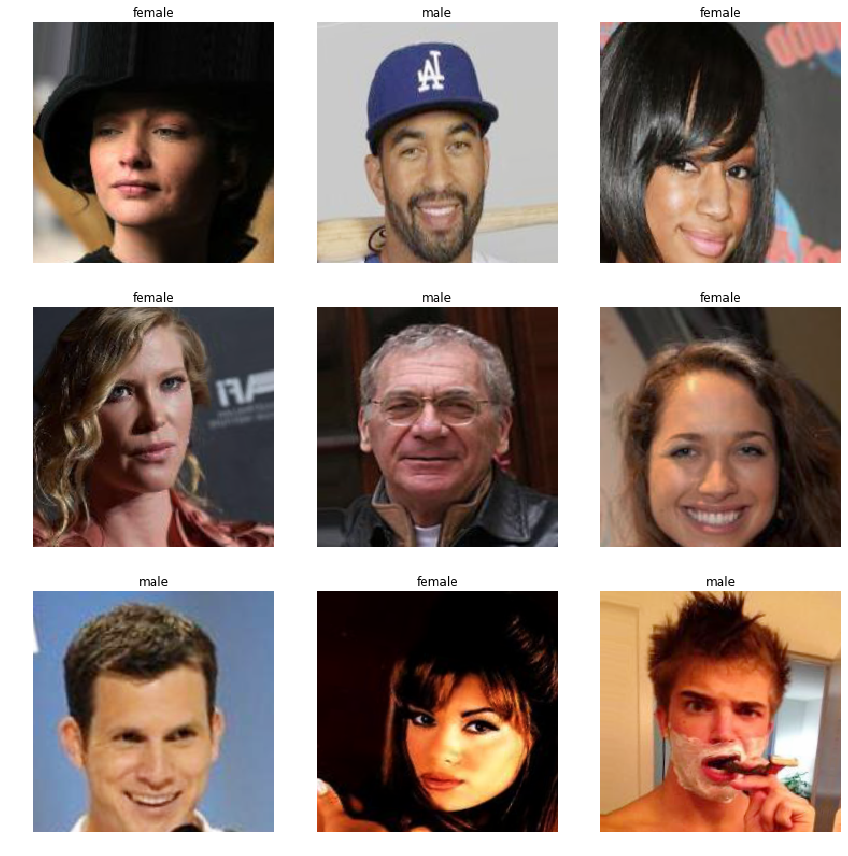

In [9]:
data.show_batch(rows=3)

# Training the Neural Network model

We will use the built-in cnn learner module from the fastai library. It creates a convolutional neural network.

In [10]:
learner = cnn_learner(data, models.resnet18, metrics=[error_rate, accuracy])

where 

* **data** is our ImageDataBunch object
* **models.resnet** is our architecture that we want to use for our Convolutional Neural Network Learner
* **metrics** are the metrices that we want to observe while training and evaluating our learner

Lets Start Training.

We'll employ the one cycle learning policy where we vary the learning rate by increasing it and then decreasing it in order to converge the model better and to overcome any local minima

In [11]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.131678,0.100378,0.038772,0.961228,18:02
1,0.096344,0.069462,0.026062,0.973938,04:54
2,0.075189,0.060711,0.021990,0.978010,04:55
3,0.080428,0.059081,0.022014,0.977986,04:54


97.8% accuracy so far. Not bad. Lets save our progress so far

In [12]:
learner.save('resnet-18-4')

## Interpreting Results

Fastai comes with a classification Interpretation module which evalues any learner on the vlidation set and generate different insights

In [13]:
interp = ClassificationInterpretation.from_learner(learner)

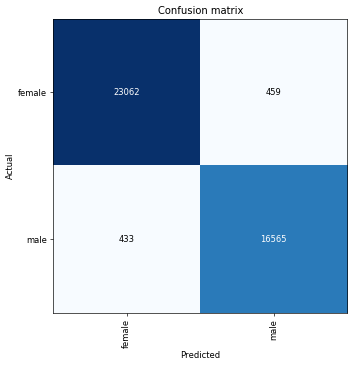

In [16]:
interp.plot_confusion_matrix(figsize=(6,6),dpi=60)

### Fine-Tuning The Learned Model

It worked pretty good but we can do better. So far our model was pretrained and frozen. Which means that all the layers of the Resnet-18 model were not being updated while we trained our model above and only the last layer was updating. The idea is that the lower level layers are basically acting as feature detectors which are then being used to train the final fully connected layer. We didn't want to update our feature detectors.

Since our final layer is trained pretty well. Lets try to fine-tune the previous layers as well. For this, we cant use the same learning rate as before since it will juse change the weights of our lower layers so fast that the basic feature detectors won't work well anymore.

In order to  find the optimal learning rate, lets call the **lr_find()** method of the learner

In [17]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


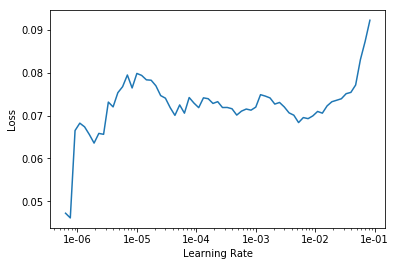

In [18]:
learner.recorder.plot()

In the above model, observe the the minima before the loss starts exploding and look the learning rate where loss starts decreasing for this minima. We'll be training the initial layers of the CNN model with smaller learning rate and the later layers with the larger learning rate. In Fastai, this can be done as, 

In [22]:
learner.fit_one_cycle(2,max_lr=slice(1e-4 / 2 , 1e-2 / 2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.045076,0.039448,0.012957,0.987043,05:06
1,0.036051,0.034488,0.011501,0.988499,05:07


In [24]:
learner.save('resnet-18-finetune-6')

### Interpreting the results

In [27]:
interp_ft = ClassificationInterpretation.from_learner(learner)

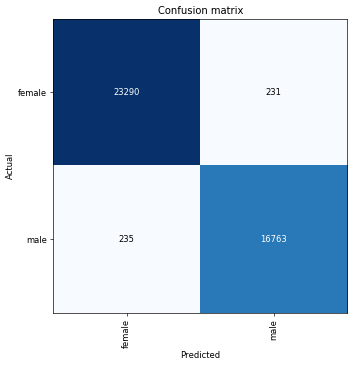

In [28]:
interp_ft.plot_confusion_matrix(dpi=60, figsize=(6,6))

Lets see the predictions which our model predicted wrong

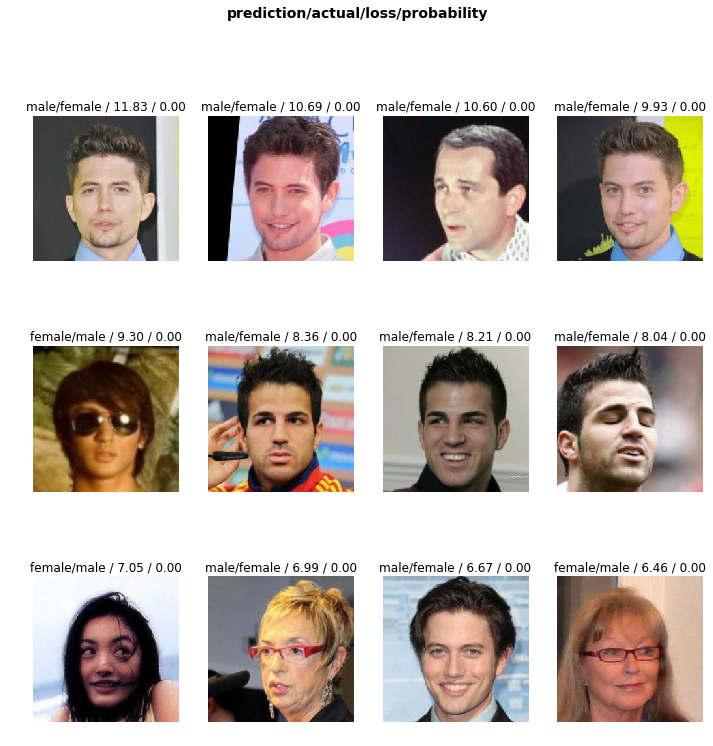

In [39]:
interp.plot_top_losses(k=12, heatmap=False)

Apparently our model is running pretty good and the data is not 100% correctly labelled.
Results above are in the Sequence of 
<center><b>prediction << actual << loss << probability of the actual class</b></center>

Our model appears to be predicting most of the images correctly even though they're labelled incorrectly. Correcting these would actually make our model's accuracy better than 99% which I might do in the future.